# Artificial Neural Networks and Deep Learning - Homework 1

- Team: Bio.log(y)

- Members: Luca Lepore, Arianna Rigamonti, Michele Sala, Jacopo Libero Tettamanti

---

## EfficeintNetV2M on pre-processed data

## ⚙️ Import libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
import keras_tuner as kt
from keras import layers as tfkl
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3


## ⏳ Load Data

In [2]:
# Load your dataset
train_augmented = np.load('/kaggle/input/def-datasets/X_train_augmented_3x.npz')
X_train = train_augmented['images']
y_train = train_augmented['labels']

val_augmented = np.load('/kaggle/input/def-datasets/X_val_augmented_3x.npz')
X_val = val_augmented['images']
y_val = val_augmented['labels']

test = np.load('/kaggle/input/def-datasets/X_test.npz')
X_test = test['images']
y_test = test['labels']

test_augmented = np.load('/kaggle/input/def-datasets/X_test_augmented_4x.npz')
X_test_augmented = test_augmented['images']
y_test_augmented = test_augmented['labels']

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Save unique labels
unique_labels = list(labels.values())
print(f'Unique labels: {unique_labels}')

Unique labels: ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [3]:
# Check the shape of the loaded datasets and images
print(f"Loaded X_train images shape: {X_train.shape}")
print(f"Loaded y_train labels shape: {y_train.shape}")
print(f"Min value X_train: {X_train.min()}, Max value X_train: {X_train.max()}\n")

print(f"Loaded X_val images shape: {X_val.shape}")
print(f"Loaded y_val labels shape: {y_val.shape}")
print(f"Min value X_val: {X_val.min()}, Max value X_val: {X_val.max()}\n")

print(f"Loaded X_test images shape: {X_test.shape}")
print(f"Loaded y_test labels shape: {y_test.shape}")
print(f"Min value X_test: {X_test.min()}, Max value X_test: {X_test.max()}\n")

print(f"Loaded X_test_augmented images shape: {X_test_augmented.shape}")
print(f"Loaded y_test_augmented labels shape: {y_test_augmented.shape}")
print(f"Min value X_test_augmented: {X_test_augmented.min()}, Max value X_test_augmented: {X_test_augmented.max()}")

Loaded X_train images shape: (21513, 96, 96, 3)
Loaded y_train labels shape: (21513, 8)
Min value X_train: 0.0, Max value X_train: 255.0

Loaded X_val images shape: (7173, 96, 96, 3)
Loaded y_val labels shape: (7173, 8)
Min value X_val: 0.0, Max value X_val: 255.0

Loaded X_test images shape: (2391, 96, 96, 3)
Loaded y_test labels shape: (2391, 8)
Min value X_test: 0, Max value X_test: 255

Loaded X_test_augmented images shape: (9564, 96, 96, 3)
Loaded y_test_augmented labels shape: (9564, 8)
Min value X_test_augmented: 0.0, Max value X_test_augmented: 255.0


### Class balancing

In [6]:
# Flatten the labels to class indices since they're in one-hot encoding
y_train_flat = np.argmax(y_train, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class weights:")
for class_index, weight in class_weight_dict.items():
    print(f"Class {class_index}: Weight {weight:.2f}")

Class weights:
Class 0: Weight 1.75
Class 1: Weight 0.69
Class 2: Weight 1.38
Class 3: Weight 0.74
Class 4: Weight 1.76
Class 5: Weight 1.50
Class 6: Weight 0.64
Class 7: Weight 0.91


## 🧮 Define Network Parameters

In [5]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [7]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 64

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 64


In [8]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [9]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

## 🔧 Hyperparameter Tuning
### RESULTS:
- Number of dense layers: 2
- units_0: 384
- dropout_0: 0.1
- units_1: 128
- dropout_1: 0.1
- learning_rate: 0.001

## 🛠️ Transfer Learning

### Optimized model construction

In [11]:
# Initialise EfficientNetV2M model with pretrained weights, for transfer learning
weights_path = '/kaggle/input/new-new-path/EfficientNetV2M.weights.h5'

base_model = tfk.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights=weights_path,
    pooling='avg',
    include_preprocessing=True
)

In [14]:
# Freeze all layers in EfficientNetV2M to use it solely as a feature extractor
base_model.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the EfficientNetV2M feature extractor
x = base_model(inputs)
# Add a Dense layer without activation
x = tfkl.Dense(384, name='dense_0')(x)
# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm_0')(x)
# Add ReLU activation
x = tfkl.Activation('relu', name='activation_0')(x)
# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.1, name='dropout_0')(x)
# Add another Dense layer without activation
x = tfkl.Dense(256, name='dense_1')(x)
# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm_1')(x)
# Add ReLU activation
x = tfkl.Activation('relu', name='activation_1')(x)
# Add another Dropout layer for regularisation
x = tfkl.Dropout(0.1, name='dropout_1')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='output_layer')(x)

# Define the complete model linking input and output
otl_model = tfk.Model(inputs=inputs, outputs=outputs, name='optimized_model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
otl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "optimized_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 1280)           │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_0                    │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_0 (Activation)       │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,745,468 (205.02 MB)

 Trainable params: 593,800 (2.27 MB)

 Non-trainable params: 53,151,668 (202.76 MB)

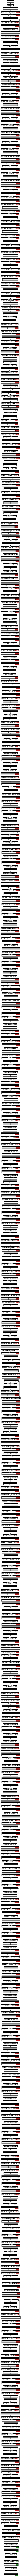

In [16]:
# Display a summary of the model architecture
otl_model.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(otl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [17]:
# Train the optimized model
otl_history = otl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(otl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'opt_EfficientNetV2M_{final_val_accuracy}.keras'
otl_model.save(model_filename)

# Free memory by deleting the model instance
del otl_model

Epoch 1/200


I0000 00:00:1732449278.994879     343 service.cc:145] XLA service 0x7bba6c120570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732449278.994931     343 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/337 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.1094 - loss: 2.6517     

I0000 00:00:1732449382.023991     343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


337/337 ━━━━━━━━━━━━━━━━━━━━ 277s 428ms/step - accuracy: 0.3874 - loss: 1.7038 - val_accuracy: 0.5565 - val_loss: 1.2205 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.5323 - loss: 1.3072 - val_accuracy: 0.5157 - val_loss: 1.3257 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.5635 - loss: 1.2200 - val_accuracy: 0.5720 - val_loss: 1.2180 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.5824 - loss: 1.1566 - val_accuracy: 0.5636 - val_loss: 1.1734 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.6032 - loss: 1.1184 - val_accuracy: 0.5806 - val_loss: 1.1535 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.6134 - loss: 1.0878 - val_accuracy: 0.6025 - val_loss: 1.0789 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.6218 - loss

In [16]:
oft_model = tfk.models.load_model('/kaggle/input/opt-tl-weights/opt_EfficientNetV2M_67.64.keras')
oft_model.get_layer('efficientnetv2-m').trainable = True

def print_model_layers(model, base_model_name):
    """
    Print the number of layers, their names, and their trainability status for a given model.

    Args:
        model: The TensorFlow/Keras model.
        base_model_name: The name of the base model layer (e.g., 'MobilenetV3small').
    """
    base_model = model.get_layer(base_model_name)
    layers = base_model.layers
    print(f"Total number of layers in '{base_model_name}': {len(layers)}\n")
    
    print("Index | Layer Name                      | Trainable")
    print("-------------------------------------------------")
    for i, layer in enumerate(layers):
        print(f"{i:<6} | {layer.name:<30} | {layer.trainable}")

print_model_layers(oft_model, 'efficientnetv2-m')

Total number of layers in 'efficientnetv2-m': 741

Index | Layer Name                      | Trainable
-------------------------------------------------
0      | input_layer                    | True
1      | rescaling                      | True
2      | stem_conv                      | True
3      | stem_bn                        | True
4      | stem_activation                | True
5      | block1a_project_conv           | True
6      | block1a_project_bn             | True
7      | block1a_project_activation     | True
8      | block1a_add                    | True
9      | block1b_project_conv           | True
10     | block1b_project_bn             | True
11     | block1b_project_activation     | True
12     | block1b_drop                   | True
13     | block1b_add                    | True
14     | block1c_project_conv           | True
15     | block1c_project_bn             | True
16     | block1c_project_activation     | True
17     | block1c_drop                   | True
1

In [17]:
# Set the number of layers to freeze
N = 396 # freeze 5 out of 7 blocks of the convolutional

# Set the first N layers as non-trainable in optimized model
for i, layer in enumerate(oft_model.get_layer('efficientnetv2-m').layers[:N]):
    layer.trainable = False

# Set the BatchNorm layers of EfficientNet as non-trainable
for layer in oft_model.get_layer('efficientnetv2-m').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# Display a summary of the model architecture
oft_model.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(oft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [18]:
# Lowering learning_rate for fine tuning
oft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [19]:
# Fine-tune the optimized model
oft_history = oft_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(oft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'opt_EfficientNetV2M_FT_' + str(final_val_accuracy) + '.keras'
oft_model.save(model_filename)

# Delete the model to free up resources
del oft_model

Epoch 1/200


I0000 00:00:1732454920.517019      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 232 bytes spill stores, 236 bytes spill loads



337/337 ━━━━━━━━━━━━━━━━━━━━ 345s 531ms/step - accuracy: 0.7098 - loss: 0.8602 - val_accuracy: 0.7421 - val_loss: 0.7611 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.8213 - loss: 0.4871 - val_accuracy: 0.7679 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.8791 - loss: 0.3250 - val_accuracy: 0.7912 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9125 - loss: 0.2326 - val_accuracy: 0.7673 - val_loss: 0.7492 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9374 - loss: 0.1686 - val_accuracy: 0.7788 - val_loss: 0.7571 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9492 - loss: 0.1331 - val_accuracy: 0.7680 - val_loss: 0.8013 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/

## Final fine tuning
Unfreeze all layers

In [20]:
# Re-load the model after first fine tuning
oft_full_model = tfk.models.load_model('/kaggle/working/opt_EfficientNetV2M_FT_83.48.keras')

# Unfreeze all layers
for i, layer in enumerate(oft_full_model.get_layer('efficientnetv2-m').layers):
    layer.trainable = True
# Set the BatchNorm layers of EfficientNet as non-trainable
for layer in oft_full_model.get_layer('efficientnetv2-m').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

Model: "optimized_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 1280)           │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_0                    │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_0 (Activation)       │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,491,478 (535.93 MB)

 Trainable params: 53,160,124 (202.79 MB)

 Non-trainable params: 585,344 (2.23 MB)

 Optimizer params: 86,746,010 (330.91 MB)

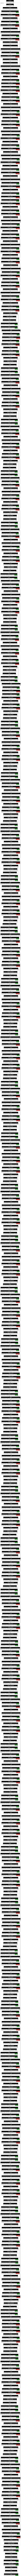

In [22]:
# Display a summary of the model architecture
oft_full_model.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(oft_full_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [24]:
# Recompile the model
oft_full_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Training with full fine tuning
oft_history_full = oft_full_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy_full = round(max(oft_history_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3 (full): {final_val_accuracy_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'opt_EfficientNetV2M_FTfull' + str(final_val_accuracy_full) + '.keras'
oft_full_model.save(model_filename)

# Delete the model to free up resources
del oft_full_model

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 420s 637ms/step - accuracy: 0.9895 - loss: 0.0317 - val_accuracy: 0.8473 - val_loss: 0.8166 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.9818 - loss: 0.0501 - val_accuracy: 0.8420 - val_loss: 0.7963 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.9873 - loss: 0.0340 - val_accuracy: 0.8415 - val_loss: 0.6352 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.9854 - loss: 0.0431 - val_accuracy: 0.8585 - val_loss: 0.6199 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 187ms/step - accuracy: 0.9910 - loss: 0.0261 - val_accuracy: 0.8564 - val_loss: 0.6589 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 187ms/step - accuracy: 0.9856 - loss: 0.0420 - val_accuracy: 0.8660 - val_loss: 0.5710 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━

## 🕹️ Use the Model - Make Inference
### Test model on test set
#### 1. Test set without augmentation

In [25]:
final_model = tfk.models.load_model('/kaggle/working/opt_EfficientNetV2M_FTfull89.81.keras')

Accuracy score over the test set: 0.9808
Precision 1 score over the test set: 0.981
Recall score 1 over the test set: 0.9808
F1 score 1 over the test set: 0.9808


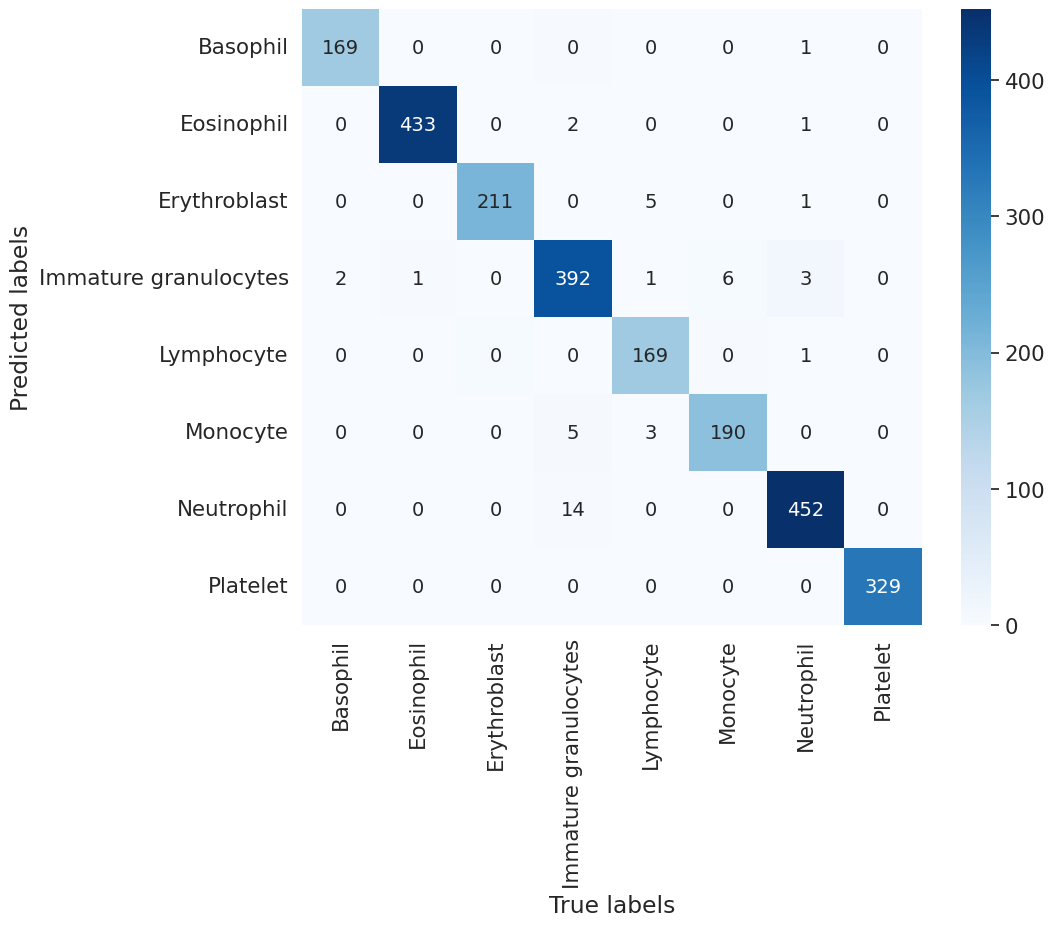

In [26]:
# Predict labels for the entire test set
test_predictions = final_model.predict(X_test, verbose=0)

# Convert predictions to class labels
test_pred_classes = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
print(f'Precision 1 score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_true_classes, test_pred_classes, average='weighted')
print(f'Recall score 1 over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')
print(f'F1 score 1 over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# Combine numbers and percentages into a single string for annotation
test_annot = np.array([f"{num}" for num in test_cm.flatten()]).reshape(test_cm.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm.T, annot=test_annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 2. Test set with augmentation

Accuracy score over the test set augmented: 0.7844
Precision 1 score over the test set: 0.783
Recall score 1 over the test set: 0.7844
F1 score 1 over the test set: 0.7831


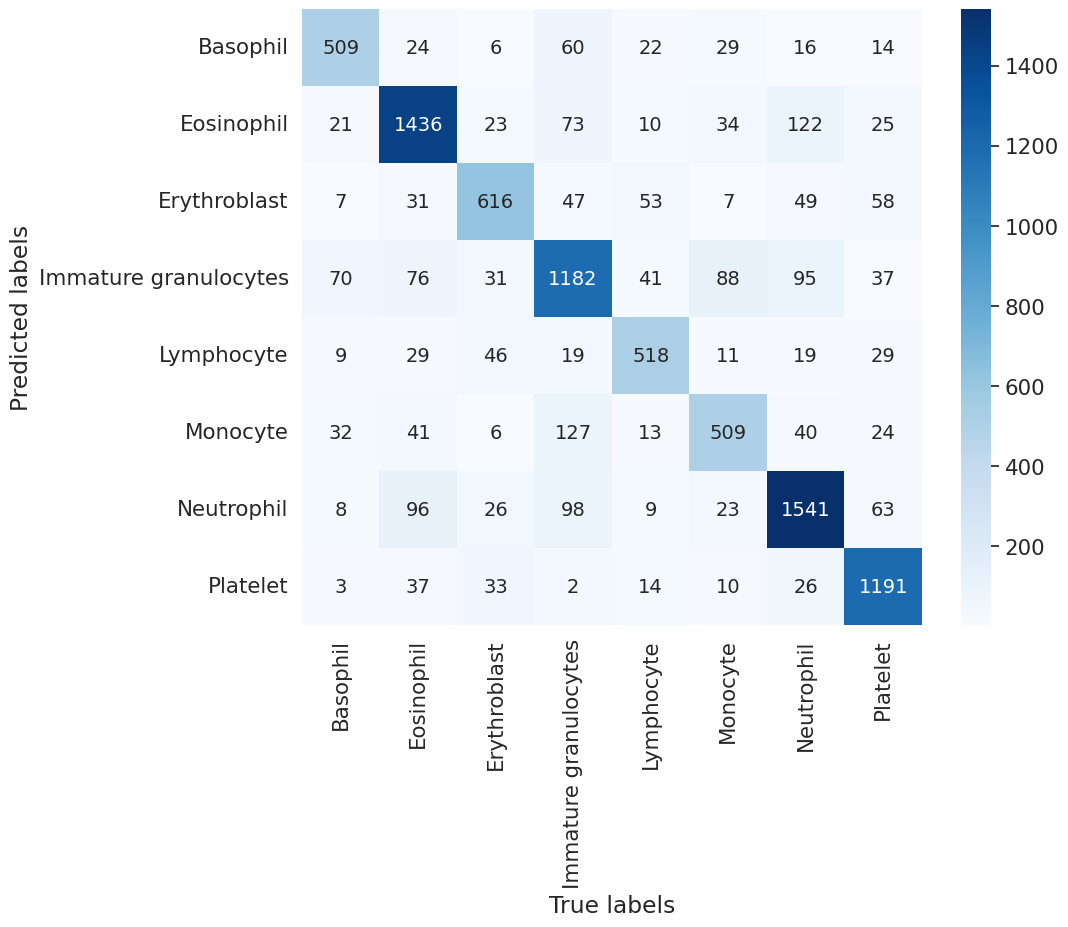

In [27]:
# Predict labels for the entire test set
test_aug_predictions = final_model.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
test_aug_pred_classes = np.argmax(test_aug_predictions, axis=-1)

# Extract ground truth classes
test_aug_true_classes = np.argmax(y_test_augmented, axis=-1)

# Calculate and display augmented test set accuracy
test_aug_accuracy = accuracy_score(test_aug_true_classes, test_aug_pred_classes)
print(f'Accuracy score over the test set augmented: {round(test_aug_accuracy, 4)}')

# Calculate and display augmented test set precision
test_aug_precision = precision_score(test_aug_true_classes, test_aug_pred_classes, average='weighted')
print(f'Precision 1 score over the test set: {round(test_aug_precision, 4)}')

# Calculate and display augmented test set recall
test_aug_recall = recall_score(test_aug_true_classes, test_aug_pred_classes, average='weighted')
print(f'Recall score 1 over the test set: {round(test_aug_recall, 4)}')

# Calculate and display test set F1 score
test_aug_f1 = f1_score(test_aug_true_classes, test_aug_pred_classes, average='weighted')
print(f'F1 score 1 over the test set: {round(test_aug_f1, 4)}')

# Compute the confusion matrix
test_aug_cm = confusion_matrix(test_aug_true_classes, test_aug_pred_classes)

# Combine numbers and percentages into a single string for annotation
test_aug_annot = np.array([f"{num}" for num in test_aug_cm.flatten()]).reshape(test_aug_cm.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_aug_cm.T, annot=test_aug_annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()